<a href="https://colab.research.google.com/github/Caroline-511/Brain_tumor_detection_using_Machine-learning_and_Image-processing-/blob/main/resnet_newdatasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir



%matplotlib inline

image=cv2.imread('/content/drive/MyDrive/BrainTumour')



In [ ]:
def crop_brain_contour(image, plot=False):
    
    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image


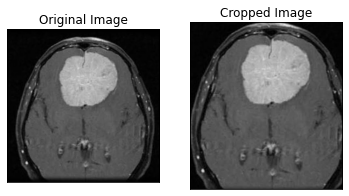

In [ ]:
ex_img = cv2.imread('/content/drive/MyDrive/BrainTumour/yes/image(1).jpg')
ex_new_img = crop_brain_contour(ex_img, True)


In [ ]:
dir_list=cv2.imread('/content/drive/MyDrive/BrainTumour')

def load_data(dir_list, image_size):
    """
    Read images, resize and normalize them. 
    Arguments:
        dir_list: list of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(directory + '//' + filename)
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y


In [ ]:
augmented_path = '/content/drive/MyDrive/NewaugData/'
# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = augmented_path + 'yes' 
augmented_no = augmented_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))


Number of examples is: 3234
X shape is: (3234, 240, 240, 3)
y shape is: (3234, 1)


In [ ]:
def plot_sample_images(X, y, n=50):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """
    
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

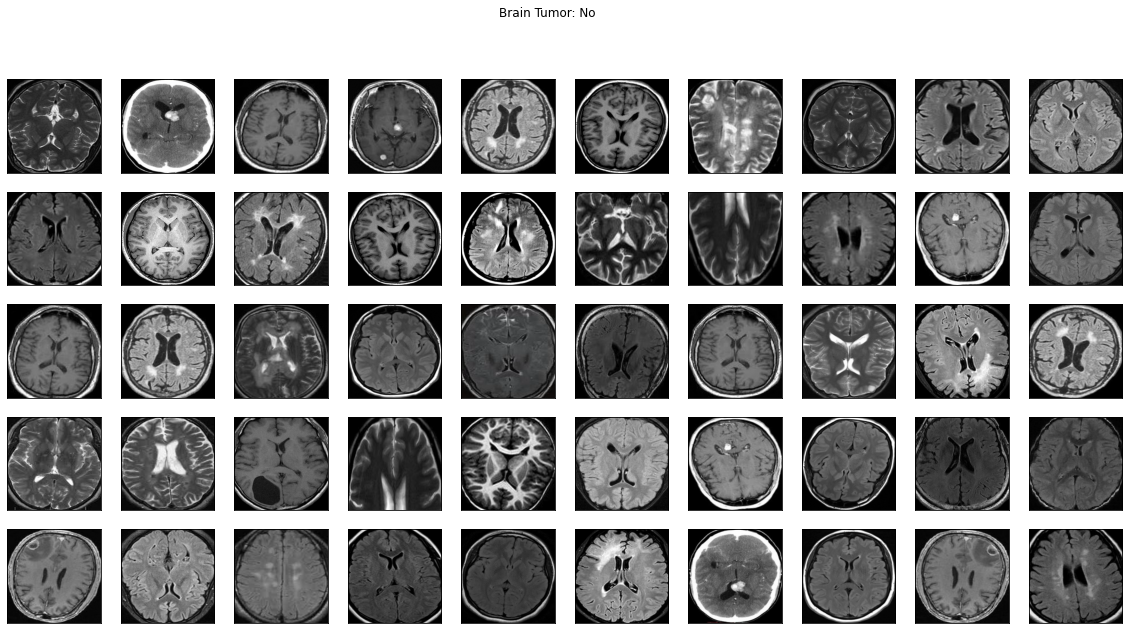

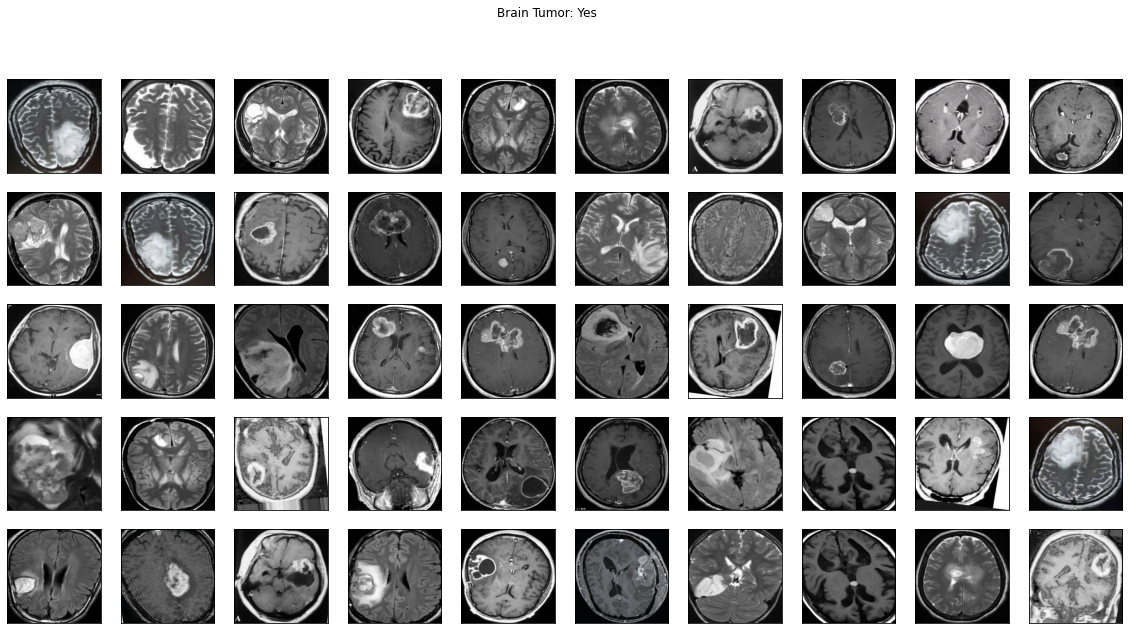

In [ ]:
plot_sample_images(X, y)


In [ ]:
def split_data(X, y, test_size=0.2):
       
    """
    Splits data into training, development and test sets.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    Returns:
        X_train: A numpy array with shape = (#_train_examples, image_width, image_height, #_channels)
        y_train: A numpy array with shape = (#_train_examples, 1)
        X_val: A numpy array with shape = (#_val_examples, image_width, image_height, #_channels)
        y_val: A numpy array with shape = (#_val_examples, 1)
        X_test: A numpy array with shape = (#_test_examples, image_width, image_height, #_channels)
        y_test: A numpy array with shape = (#_test_examples, 1)
    """
    
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test


In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)


In [ ]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 2263
number of development examples = 486
number of test examples = 485
X_train shape: (2263, 240, 240, 3)
Y_train shape: (2263, 1)
X_val (dev) shape: (486, 240, 240, 3)
Y_val (dev) shape: (486, 1)
X_test shape: (485, 240, 240, 3)
Y_test shape: (485, 1)


In [ ]:
from keras.models import Sequential
from keras.layers import Dense,Flatten
from keras.applications.resnet50 import ResNet50
import keras.backend as K
K.set_image_data_format('channels_last')


In [ ]:
new_model = Sequential()                                                               # defining the model instance in keras
new_model.add(ResNet50(include_top = False, input_shape = (240,240,3), classes = 2))   # inbuilt resnet weights from ImageNet
new_model.add(Flatten())                                                               # flatenning the resnet output
new_model.add(Dense(1, activation = 'sigmoid'))                                        # the last sigmoid layer with one node for classification


94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
new_model.compile(
    loss = 'binary_crossentropy',      # loss function
    optimizer = 'adam',                # optimizer
    metrics = ['accuracy']             # report accuracy during training
)

In [ ]:
print(new_model.summary())             # printing the model's summary


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 1)                 131073    
Total params: 23,718,785
Trainable params: 23,665,665
Non-trainable params: 53,120
_________________________________________________________________
None


In [ ]:
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'/content/drive/MyDrive/Logs/{log_file_name}')

In [ ]:
filepath="cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}"
# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint("/content/drive/MyDrive/Models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'))


In [ ]:

start_time = time.time()

new_model.fit(x=X_train, y=y_train,                  
                        batch_size=1,            
                        epochs = 10,  
                        validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])
end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {(execution_time)}")

Epoch 1/10
2263/2263 [==============================] - 1854s 817ms/step - loss: 3.1285 - accuracy: 0.6407 - val_loss: 1271.2961 - val_accuracy: 0.5062
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/cnn-parameters-improvement-01-0.51.model/assets
Epoch 2/10
2263/2263 [==============================] - 1910s 844ms/step - loss: 1.1263 - accuracy: 0.5734 - val_loss: 1.0435 - val_accuracy: 0.4877
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/cnn-parameters-improvement-02-0.49.model/assets
Epoch 3/10
2263/2263 [==============================] - 1951s 862ms/step - loss: 0.6074 - accuracy: 0.7169 - val_loss: 0.6014 - val_accuracy: 0.6708
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/cnn-parameters-improvement-03-0.67.model/assets
Epoch 4/10
2263/2263 [==============================] - 1955s 864ms/step - loss: 0.4051 - accuracy: 0.8424 - val_loss: 1.0775 - val_accuracy: 0.6481
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Mode

In [ ]:
history = new_model.history.history


In [ ]:
for key in history.keys():
    print(key)


loss
accuracy
val_loss
val_accuracy


In [ ]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()


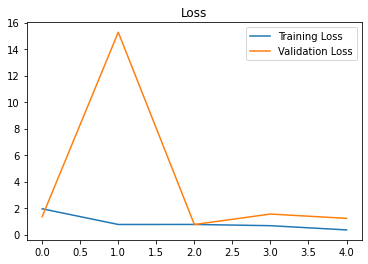

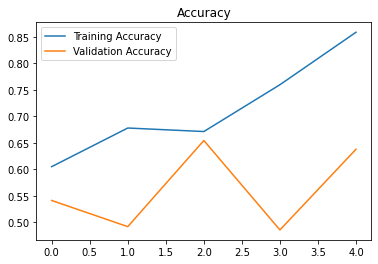

In [ ]:
plot_metrics(history)



In [ ]:
best_model = load_model(filepath='/content/drive/MyDrive/Models/cnn-parameters-improvement-10-0.73.model')


In [ ]:
best_model.metrics_names


['loss', 'accuracy']

In [ ]:
loss, acc = best_model.evaluate(x=X_test, y=y_test)


16/16 [==============================] - 63s 4s/step - loss: 12.2324 - accuracy: 0.7258


In [ ]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")


Test Loss = 12.232390403747559
Test Accuracy = 0.7257732152938843


In [ ]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score


In [ ]:
y_test_prob = best_model.predict(X_test)


In [ ]:
f1score = compute_f1_score(y_test, y_test_prob)
print(f"F1 score: {f1score}")


F1 score: 0.7686956521739131


In [ ]:
y_val_prob = best_model.predict(X_val)


In [ ]:
f1score_val = compute_f1_score(y_val, y_val_prob)
print(f"F1 score: {f1score_val}")


F1 score: 0.7493670886075949


In [ ]:
def data_percentage(y):
    
    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive
    
    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {n_positive}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {n_negative}")

In [ ]:
data_percentage(y)


Number of examples: 3234
Percentage of positive examples: 48.97959183673469%, number of pos examples: 1584
Percentage of negative examples: 51.02040816326531%, number of neg examples: 1650


In [ ]:

print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)


Training Data:
Number of examples: 1622
Percentage of positive examples: 54.00739827373613%, number of pos examples: 876
Percentage of negative examples: 45.99260172626387%, number of neg examples: 746
Validation Data:
Number of examples: 348
Percentage of positive examples: 50.86206896551724%, number of pos examples: 177
Percentage of negative examples: 49.13793103448276%, number of neg examples: 171
Testing Data:
Number of examples: 348
Percentage of positive examples: 53.735632183908045%, number of pos examples: 187
Percentage of negative examples: 46.264367816091955%, number of neg examples: 161
